In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os
import configs
from math import floor, ceil

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
from utils_summary_statistics import *
import configs

# Choose experiment to load

In [2]:
# Specify what you're looking at
exp = 'narrow_search_factor'
model_type = 'default'

In [3]:
if os.environ['USER'] == 'chingfang':
    engram_dir = '/Volumes/aronov-locker/Ching/barcodes/' # Local Path
elif 'SLURM_JOBID' in os.environ.keys():
    engram_dir = '/mnt/smb/locker/aronov-locker/Ching/barcodes/' # Axon Path
else:
    engram_dir = '/home/cf2794/engram/Ching/barcodes/' # Cortex Path
exp_dir = os.path.join(engram_dir, 'resolution', exp, model_type)
cap_dir = os.path.join(engram_dir, 'capacity', exp, model_type)

In [4]:
N_inp = 5000
N_bar = 5000
num_states = 100
inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [5]:
load = True

In [6]:
if load:
    with open('pickles/capacity_default.p', 'rb') as f:
        summary_stats = pickle.load(f)
else:
    summary_stats = {}

    for base_dir in [cap_dir, exp_dir]:
        for param in os.listdir(base_dir):
            if param == '.DS_Store': continue
            dirpath = os.path.join(base_dir, param)
            for site_spacing in os.listdir(dirpath):
                if not site_spacing.startswith('spacing'): continue    
                dirpath = os.path.join(base_dir, param, site_spacing)
                for n_cache in os.listdir(dirpath):
                    if not n_cache.startswith('caches'): continue
                    if n_cache == 'caches1': continue
                    dirpath = os.path.join(base_dir, param, site_spacing, n_cache)

                    for seed in os.listdir(dirpath):
                        if not seed.startswith('seed'): continue
                        dirpath = os.path.join(base_dir, param, site_spacing, n_cache, seed)
                        _param = round(float(param), 1)
                        _site_spacing = int(site_spacing[7:])
                        _n_cache = int(n_cache[6:])
                        _seed = int(seed[4:])

                        cache_states = [int(n*_site_spacing) for n in range(_n_cache)]
                        try:
                            with open(os.path.join(dirpath, 'results.p'), 'rb') as f:
                                _results = pickle.load(f)
                        except:
                            continue
                        readout = np.linalg.norm(_results['narrow_reconstruct'], axis=1)
                        readout /= readout.max()
                        reconstruct = _results['narrow_reconstruct']
                        activations = _results['narrow_acts'].copy()
                        _summary_stats = get_resolution_summary_statistics(
                            readout, reconstruct, cache_states, activations,
                            inputs, _site_spacing, search_strength=_param)
                        for key, _dict in _summary_stats.items():
                            n_samples = len(_dict[list(_dict.keys())[0]])
                            if key not in summary_stats.keys():
                                summary_stats[key] = _dict
                            else:
                                for nested_key in _dict.keys():
                                    summary_stats[key][nested_key].extend(_dict[nested_key])

    with open('pickles/capacity_default.p', 'wb') as f:
        pickle.dump(summary_stats, f)

In [7]:
df = pd.DataFrame(summary_stats['identification_2'])

# Identifying the Presence of a Cache

### Are you correct at sites between cache 1 and cache 2?

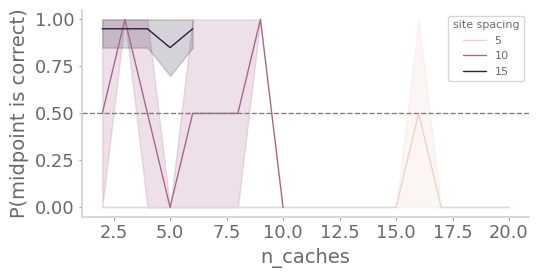

In [8]:
df = pd.DataFrame(summary_stats['identification_2'])
df = df[df['search strength']==0]
df['binarized'] = df['noncache val'] < 0.5
fig, ax = plt.subplots(figsize=(5.5,3))
sns.lineplot(
    x='n_caches', y='binarized', hue='site spacing',
    ax=ax, data=df)
ax.axhline(0.5, color='gray', linestyle='--')
plt.ylabel('P(midpoint is correct)')
plt.tight_layout()
plt.savefig('midpoint_correct.png', dpi=300)
plt.show()

### Are you correct at non-caches away from a cache site?

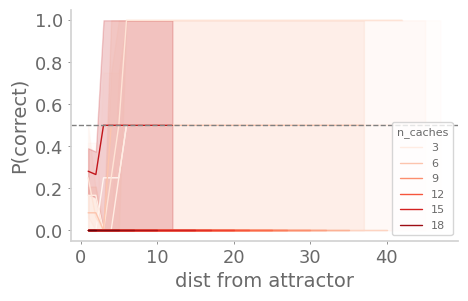

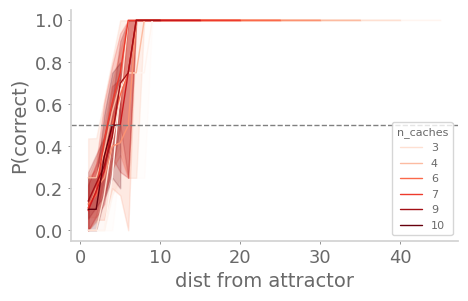

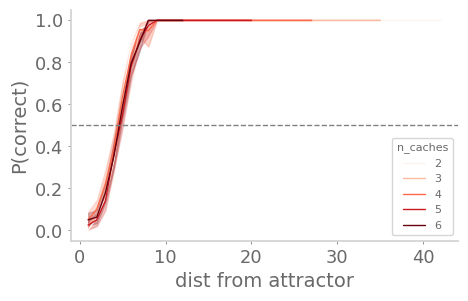

In [9]:
for site_spacing in [5, 10, 15]:
    df = pd.DataFrame(summary_stats['identification_3'])
    df = df[df['search strength']==0]
    df = df[df['site spacing'] == site_spacing]
    df['binarized'] = df['val'] < 0.5
    fig, ax = plt.subplots(figsize=(5,3))
    sns.lineplot(
        x='dist from attractor', y ='binarized',
        hue='n_caches', data=df, palette='Reds'
        )
    ax.axhline(0.5, color='gray', linestyle='--')
    plt.ylabel('P(correct)')
    plt.show()

### Performance on caches

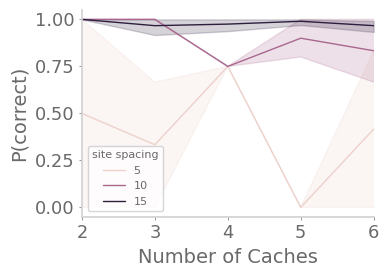

In [30]:
df = pd.DataFrame(summary_stats['identification_5'])
df = df[df['search strength'] == 0.]
df['p_correct'] = df['n_caches_correct']/df['n_caches']
fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(
    x='n_caches', y ='p_correct',
    data=df, hue='site spacing'
    )
plt.xlim(2, 6)
plt.tight_layout()
plt.xlabel('Number of Caches')
plt.ylabel('P(correct)')
plt.show()

# Reconstruction

### Probability of valid attractor given optimal attractor distance

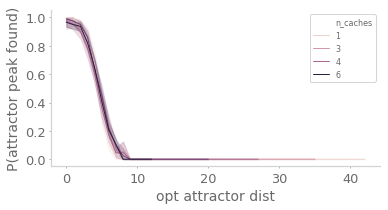

In [30]:
df = pd.DataFrame(summary_stats['reconstruct_1'])
df = df[df['search strength'] == 0.]
fig, ax = plt.subplots(figsize=(5.5,3))
sns.lineplot(
    x='opt attractor dist', y='p_valid', hue='n_caches',
    data=df
    )
plt.ylabel('P(attractor peak found)')
plt.tight_layout()
plt.savefig('reconstruction_pfound.png', dpi=300)
plt.show()